In [1]:
import findspark
findspark.init()
findspark.find()
import pyspark

import os
import functools as reduce
from pyspark.context import SparkContext
from pyspark.sql import DataFrame, SQLContext, SparkSession, Window
from pyspark.sql.functions import *
from pyspark.sql.types import *

conf = pyspark.SparkConf().setAppName('MLLib-Linear Regression').setMaster('local')
sc = pyspark.SparkContext(conf = conf)
spark = SparkSession(sc)
sqlContext = SQLContext(sc)

In [2]:
spark

In [3]:
# Importing relevant libraries
from sklearn import datasets
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import VectorAssembler, StringIndexer
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
boston = datasets.load_boston()

df = pd.DataFrame(boston.data, columns=boston.feature_names)
df['price'] = boston.target
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,price
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


In [5]:
sdf = spark.createDataFrame(df)
sdf.show(truncate = False)

+-------+----+-----+----+-----+-----+-----+------+---+-----+-------+------+-----+-----+
|CRIM   |ZN  |INDUS|CHAS|NOX  |RM   |AGE  |DIS   |RAD|TAX  |PTRATIO|B     |LSTAT|price|
+-------+----+-----+----+-----+-----+-----+------+---+-----+-------+------+-----+-----+
|0.00632|18.0|2.31 |0.0 |0.538|6.575|65.2 |4.09  |1.0|296.0|15.3   |396.9 |4.98 |24.0 |
|0.02731|0.0 |7.07 |0.0 |0.469|6.421|78.9 |4.9671|2.0|242.0|17.8   |396.9 |9.14 |21.6 |
|0.02729|0.0 |7.07 |0.0 |0.469|7.185|61.1 |4.9671|2.0|242.0|17.8   |392.83|4.03 |34.7 |
|0.03237|0.0 |2.18 |0.0 |0.458|6.998|45.8 |6.0622|3.0|222.0|18.7   |394.63|2.94 |33.4 |
|0.06905|0.0 |2.18 |0.0 |0.458|7.147|54.2 |6.0622|3.0|222.0|18.7   |396.9 |5.33 |36.2 |
|0.02985|0.0 |2.18 |0.0 |0.458|6.43 |58.7 |6.0622|3.0|222.0|18.7   |394.12|5.21 |28.7 |
|0.08829|12.5|7.87 |0.0 |0.524|6.012|66.6 |5.5605|5.0|311.0|15.2   |395.6 |12.43|22.9 |
|0.14455|12.5|7.87 |0.0 |0.524|6.172|96.1 |5.9505|5.0|311.0|15.2   |396.9 |19.15|27.1 |
|0.21124|12.5|7.87 |0.0 |0.524|5

In [6]:
assembler = VectorAssembler(inputCols=[c for c in sdf.columns if c != "price"],
                           outputCol="features")
dataset = assembler.transform(sdf)
sdf.show(5, truncate=False)

+-------+----+-----+----+-----+-----+----+------+---+-----+-------+------+-----+-----+
|CRIM   |ZN  |INDUS|CHAS|NOX  |RM   |AGE |DIS   |RAD|TAX  |PTRATIO|B     |LSTAT|price|
+-------+----+-----+----+-----+-----+----+------+---+-----+-------+------+-----+-----+
|0.00632|18.0|2.31 |0.0 |0.538|6.575|65.2|4.09  |1.0|296.0|15.3   |396.9 |4.98 |24.0 |
|0.02731|0.0 |7.07 |0.0 |0.469|6.421|78.9|4.9671|2.0|242.0|17.8   |396.9 |9.14 |21.6 |
|0.02729|0.0 |7.07 |0.0 |0.469|7.185|61.1|4.9671|2.0|242.0|17.8   |392.83|4.03 |34.7 |
|0.03237|0.0 |2.18 |0.0 |0.458|6.998|45.8|6.0622|3.0|222.0|18.7   |394.63|2.94 |33.4 |
|0.06905|0.0 |2.18 |0.0 |0.458|7.147|54.2|6.0622|3.0|222.0|18.7   |396.9 |5.33 |36.2 |
+-------+----+-----+----+-----+-----+----+------+---+-----+-------+------+-----+-----+
only showing top 5 rows



In [7]:
dataset.select("features").show(truncate=False)

+----------------------------------------------------------------------------+
|features                                                                    |
+----------------------------------------------------------------------------+
|[0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.09,1.0,296.0,15.3,396.9,4.98]     |
|[0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.9,9.14]    |
|[0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03]   |
|[0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94]   |
|[0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.9,5.33]    |
|[0.02985,0.0,2.18,0.0,0.458,6.43,58.7,6.0622,3.0,222.0,18.7,394.12,5.21]    |
|[0.08829,12.5,7.87,0.0,0.524,6.012,66.6,5.5605,5.0,311.0,15.2,395.6,12.43]  |
|[0.14455,12.5,7.87,0.0,0.524,6.172,96.1,5.9505,5.0,311.0,15.2,396.9,19.15]  |
|[0.21124,12.5,7.87,0.0,0.524,5.631,100.0,6.0821,5.0,311.0,15.2,386.63,29.93]|
|[0.17004,12.5,7.87,0.0,0.524,6.004,85.9,6.5921,5.0,

In [8]:
"""
By caching you create a checkpoint in your spark application 
and if further down the execution of application any of the 
tasks fail your application will be able to recompute the 
lost RDD partition from the cache.
"""
dataset.cache()

DataFrame[CRIM: double, ZN: double, INDUS: double, CHAS: double, NOX: double, RM: double, AGE: double, DIS: double, RAD: double, TAX: double, PTRATIO: double, B: double, LSTAT: double, price: double, features: vector]

In [9]:
lr = LinearRegression(featuresCol="features", labelCol="price")
model = lr.fit(dataset)

##### Importance of Individual Features

In [10]:
model.coefficients

DenseVector([-0.108, 0.0464, 0.0206, 2.6867, -17.7666, 3.8099, 0.0007, -1.4756, 0.306, -0.0123, -0.9527, 0.0093, -0.5248])

In [11]:
assembler.getInputCols()

['CRIM',
 'ZN',
 'INDUS',
 'CHAS',
 'NOX',
 'RM',
 'AGE',
 'DIS',
 'RAD',
 'TAX',
 'PTRATIO',
 'B',
 'LSTAT']

<AxesSubplot:>

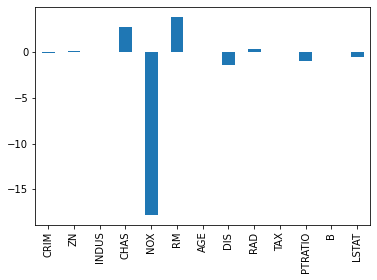

In [12]:
pd.Series(np.array(model.coefficients), index=assembler.getInputCols()).plot(kind='bar')

In [13]:
# Getting Metrics
summary = model.evaluate(dataset)
summary.r2

0.7406426641094093

In [14]:
summary.explainedVariance

62.52472497442836

In [15]:
# Training on a subset of the dataset including only a few features
subset = sdf.select("CHAS", "NOX", "RM", "price")
assembler = VectorAssembler(inputCols=[col for col in subset.columns if col != "price"],
                           outputCol="features")
small_dataset = assembler.transform(subset)
small_dataset.show()

+----+-----+-----+-----+-----------------+
|CHAS|  NOX|   RM|price|         features|
+----+-----+-----+-----+-----------------+
| 0.0|0.538|6.575| 24.0|[0.0,0.538,6.575]|
| 0.0|0.469|6.421| 21.6|[0.0,0.469,6.421]|
| 0.0|0.469|7.185| 34.7|[0.0,0.469,7.185]|
| 0.0|0.458|6.998| 33.4|[0.0,0.458,6.998]|
| 0.0|0.458|7.147| 36.2|[0.0,0.458,7.147]|
| 0.0|0.458| 6.43| 28.7| [0.0,0.458,6.43]|
| 0.0|0.524|6.012| 22.9|[0.0,0.524,6.012]|
| 0.0|0.524|6.172| 27.1|[0.0,0.524,6.172]|
| 0.0|0.524|5.631| 16.5|[0.0,0.524,5.631]|
| 0.0|0.524|6.004| 18.9|[0.0,0.524,6.004]|
| 0.0|0.524|6.377| 15.0|[0.0,0.524,6.377]|
| 0.0|0.524|6.009| 18.9|[0.0,0.524,6.009]|
| 0.0|0.524|5.889| 21.7|[0.0,0.524,5.889]|
| 0.0|0.538|5.949| 20.4|[0.0,0.538,5.949]|
| 0.0|0.538|6.096| 18.2|[0.0,0.538,6.096]|
| 0.0|0.538|5.834| 19.9|[0.0,0.538,5.834]|
| 0.0|0.538|5.935| 23.1|[0.0,0.538,5.935]|
| 0.0|0.538| 5.99| 17.5| [0.0,0.538,5.99]|
| 0.0|0.538|5.456| 20.2|[0.0,0.538,5.456]|
| 0.0|0.538|5.727| 18.2|[0.0,0.538,5.727]|
+----+-----

In [16]:
lr = LinearRegression(featuresCol="features", labelCol="price")
small_model = lr.fit(small_dataset)
summary = small_model.evaluate(small_dataset)

In [17]:
summary.r2

0.555573713059086

In [18]:
summary.explainedVariance

46.90128626848128

`Note:` Only a couple of metrics are explaining the huge part of the Variance in the dataset

### Fitting the Linear Regression on the Diabetes dataset

In [19]:
# Step1: Create a Spark Dataframe and prepare the dataset
diabetes = datasets.load_diabetes()
df = pd.DataFrame(diabetes.data, columns=diabetes.feature_names)
df['y'] = diabetes.target

# Converting pandas dataframe in Spark dataframe
sdf = spark.createDataFrame(df)

assembler = VectorAssembler(inputCols=[col for col in df.columns if col!="y"],
                           outputCol="features")
dataset = assembler.transform(sdf)

In [20]:
# Step2: Fitting the model and finding R2 score and Explained Variance
lr = LinearRegression(featuresCol="features", labelCol="y")
model = lr.fit(dataset)
summary = model.evaluate(dataset)
print(summary.r2, summary.explainedVariance)

0.5177494254132935 3070.1944981422444


<AxesSubplot:>

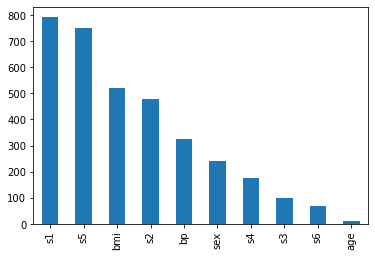

In [21]:
# Step3: Plotting to see what features are important
pd.Series(model.coefficients, index=assembler.getInputCols()).abs().sort_values(ascending=False).plot(kind="bar")

`Note:` We will consider top-4 features affecting diabetes, i.e., "s1", "s5", "bmi", "s2"

In [22]:
# Step4: Training a new model on this subset and finding R2 and Explained Variance
subset = dataset.select("s1", "s5", "bmi", "s2", "y")
assembler = VectorAssembler(inputCols=[col for col in subset.columns if col != "y"],
                            outputCol="features")
dataset = assembler.transform(subset)

In [23]:
# Step2: Fitting the model and finding R2 score and Explained Variance
lr = LinearRegression(featuresCol="features", labelCol="y")
model = lr.fit(dataset)
summary = model.evaluate(dataset)
print(summary.r2, summary.explainedVariance)

0.4764751603914338 2825.442857358158


In [24]:
0.4764751603914338/0.5177494254132935 

0.9202813890350288

`Note:` We can see that 92% of the variance is explained by these 4 selected variables only.